#  <center>Clustering</center>

In [2]:
import numpy as np

s1 = np.array([2, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=float)
s2 = np.array([0, 2, 1, 1, 0, 0, 0, 1, 2, 1], dtype=float)


In [4]:
print(s1)
print(s2)


[2. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
[0. 2. 1. 1. 0. 0. 0. 1. 2. 1.]


### 1. Calculate using Cosine Function

In [5]:
cosine_similarity = np.dot(s1, s2)/(np.sqrt(np.sum(s1**2)) * np.sqrt(np.sum(s2**2)))
cosine_distance = 1 - cosine_similarity
cosine_distance

0.5648058601107554

### 2.Calculate using Euclidean Distance

In [6]:
euclidean_distance = np.sqrt(np.sum((s1 - s2)**2))
euclidean_distance

3.605551275463989

## Choosing features and metrics for nearest neighbor search

In [11]:
import pandas as pd                      # see below for install instruction
import matplotlib.pyplot as plt          # plotting
import numpy as np                       # dense matrices
from scipy.sparse import csr_matrix      # sparse matrices
%matplotlib inline

In [12]:
wiki = pd.read_csv('people_wiki.csv')

In [13]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


## Extract word count vectors

In [14]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [15]:
word_count = load_sparse_csr('people_wiki_word_count.npz')

In [16]:
word_count

<59071x547979 sparse matrix of type '<class 'numpy.int64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [18]:
def remove_punctuation(text):
    import string
    return text.translate(string.punctuation) 
wiki['text_clean'] = wiki['text'].apply(remove_punctuation)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
word_count_matrix = vectorizer.fit_transform(wiki['text_clean'])

In [20]:
word_count_matrix

<59071x548465 sparse matrix of type '<class 'numpy.int64'>'
	with 10379588 stored elements in Compressed Sparse Row format>

## Find nearest neighbors using word count vectors

In [22]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', metric='euclidean')

In [23]:
print(wiki[wiki['name'] == 'Barack Obama'])

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  \
35817  barack hussein obama ii brk husen bm born augu...   

                                              text_clean  
35817  barack hussein obama ii brk husen bm born augu...  


###  K nearest neughbours for Obama' Article. 

In [25]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10)

In [34]:
print("distance:")
print(distances)

print("                                                                 ")
print("Indices:")
print(indices)


distance:
[[ 0.         33.07567082 34.39476704 36.15245497 36.16628264 36.33180425
  36.40054945 36.49657518 36.63331817 36.95943723]]
                                                                 
Indices:
[[35817 24478 28447 35357 14754 13229 31423 22745 36364  9210]]


In [35]:
distances.flatten()

array([ 0.        , 33.07567082, 34.39476704, 36.15245497, 36.16628264,
       36.33180425, 36.40054945, 36.49657518, 36.63331817, 36.95943723])

In [37]:
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
neighbors['id'].dtype


dtype('int64')

In [44]:
wiki['id'] = wiki.index
df =pd.merge(wiki, neighbors, how = 'inner', on='id')[['id','name','distance']]
df.sort_values('distance', ascending = True)

,id,name,distance
8,35817,Barack Obama,0.000000
4,24478,Joe Biden,33.075671
5,28447,George W. Bush,34.394767
7,35357,Lawrence Summers,36.152455
2,14754,Mitt Romney,36.166283
1,13229,Francisco Barrio,36.331804
6,31423,Walter Mondale,36.400549
3,22745,Wynn Normington Hugh-Jones,36.496575
9,36364,Don Bonker,36.633318
0,9210,Andy Anstett,36.959437


##  Interpreting the nearest neighbors

In [45]:
import json
with open('people_wiki_map_index_to_word.json', 'r') as f: # Reads the list of most frequent words
    map_index_to_word = json.load(f)

In [47]:
def unpack_dict(matrix, map_index_to_word):
    ##table = list(map_index_to_word.sort('index')['category'])
    # if you're not using SFrame, replace this line with
    table = sorted(map_index_to_word, key=map_index_to_word.get)
    
    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in range(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [48]:
word_count.shape

(59071, 547979)

In [50]:
wiki['word_count']

0        {'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...
1        {'maladaptation': 1, 'phasedelay': 1, '25hour'...
2        {'germanyover': 1, 'bluesgospel': 1, 'harpdog'...
3        {'fantasticrottensteiner': 1, 'waidmannsfeld':...
4        {'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...
5        {'historyhenderson': 1, 'onteora': 1, '1991hen...
6        {'pellatfinet': 1, 'lacrates': 1, 'baltimoreaa...
7        {'2014city': 1, 'kinkajou': 1, 'bunkhousesin':...
8        {'garagehe': 1, 'hardcores': 1, 'wishdokta': 3...
9        {'caruths': 1, 'deborash': 1, '173182': 1, 'ca...
10       {'americanfrench': 1, 'kominskycrumbcrumb': 1,...
11       {'quillercouch': 1, 'universityashworths': 1, ...
12       {'splithoefler': 1, 'morninghoeflers': 1, 'hef...
13       {'8595gueterbock': 1, 'fitzhardinge': 1, 'corn...
14       {'bodieschernushenko': 1, '2013chernushenko': ...
15       {'84minute': 1, 'steineck': 4, 'truckfighters'...
16       {'collaborationfr': 1, 'secondperson': 2, 'mar.

In [53]:

def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    for i in row['word_count']:
        word_count_table = pd.DataFrame(i.items(), columns = ['word','count'])
    return word_count_table.sort_values('count', ascending=False)

obama_words = top_words('Barack Obama')
print(obama_words.head())

barrio_words = top_words('Francisco Barrio')
print(barrio_words.head())

    word  count
272  the     40
270   in     30
271  and     21
269   of     18
266   to     14
    word  count
224  the     36
221   of     24
223  and     18
222   in     17
212   he     10


In [55]:
combined_words = pd.merge(obama_words, barrio_words, how = 'inner', on = 'word')

In [56]:
combined_words.rename(columns = {'count_x': 'Obama', 'count_y': 'Barrio'}, inplace=True)

In [57]:

combined_words.head()

,word,Obama,Barrio
0,the,40,36
1,in,30,17
2,and,21,18
3,of,18,24
4,to,14,9


In [58]:
combined_words.sort_values('Obama', ascending=False).head()

,word,Obama,Barrio
0,the,40,36
1,in,30,17
2,and,21,18
3,of,18,24
4,to,14,9


In [60]:

common_words = set([m for m in combined_words[0:5]['word']])

print(common_words)

{'in', 'of', 'to', 'and', 'the'}


In [62]:

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set([k for k,v in word_count_vector.items()])   
    # return True if common_words is a subset of unique_words
    return common_words.issubset(unique_words)

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)
sum(wiki['has_top_words'] == True)

56066

In [64]:
print('Output from your function:', has_top_words(wiki.iloc[32]['word_count']))
len(set([k for k,v in wiki.iloc[32]['word_count'].items()]))

Output from your function: True


167

In [66]:
from sklearn.metrics.pairwise import euclidean_distances
obama_matrix = wiki[wiki['name'] == 'Barack Obama']['word_count']
bush_matrix = wiki[wiki['name'] == 'George W. Bush']['word_count']
joe_matrix = wiki[wiki['name'] == 'Joe Biden']['word_count']
o = int(wiki[wiki['name'] == 'Barack Obama']['id'])
b = int(wiki[wiki['name'] == 'George W. Bush']['id'])
j = int(wiki[wiki['name'] == 'Joe Biden']['id'])

In [68]:
bush_matrix.index
joe_matrix.index
o_b = euclidean_distances(word_count[o], word_count[b])
o_j = euclidean_distances(word_count[o], word_count[j])
b_j = euclidean_distances(word_count[b], word_count[j])

print("euclidean_distances for obama and bush is: ", o_b)
print("euclidean_distances for obama and joe is: ", o_j)
print("euclidean_distances for bush and joe is: ", b_j)

euclidean_distances for obama and bush is:  [[34.39476704]]
euclidean_distances for obama and joe is:  [[33.07567082]]
euclidean_distances for bush and joe is:  [[32.75667871]]


In [72]:
obama_words = top_words('Barack Obama')
bush_words = top_words('George W. Bush')
ob_combined_words = pd.merge(obama_words, bush_words, how='inner', on = 'word')
ob_combined_words.sort_values('count_x', ascending=False)[0:10]

,word,count_x,count_y
0,the,40,39
1,in,30,22
2,and,21,14
3,of,18,14
4,to,14,11
5,his,11,6
6,act,8,3
7,he,7,8
8,a,7,6
9,law,6,1


## KDTREE


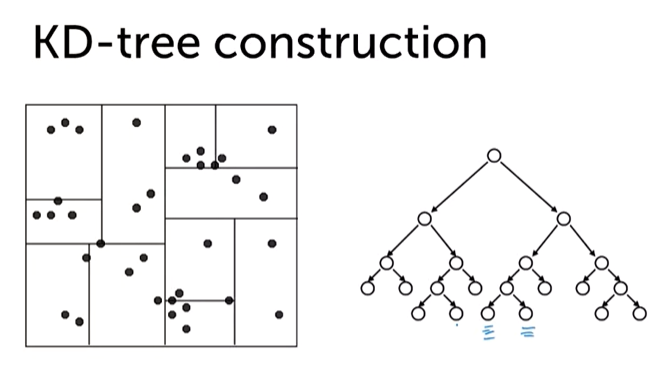

In [10]:

from IPython.display import Image
Image(filename='KDtree.PNG')